In [ ]:
import pickle
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Import modules from the backtester package
from order_generator import BettingAgainstBetaOrderGenerator
from backtest_engine import EquityBacktestEngine
from metrics import ExtendedMetrics

# first, run python cache_sp500_data.py to prevent caching all universe every run, then run this script
with open('sp500_data.pkl', 'rb') as f:
    sp500_data = pickle.load(f)

if 'SPY' not in sp500_data:
    sample_ticker = list(sp500_data.keys())[0]
    dates = sp500_data[sample_ticker].index
    start_date = dates.min().strftime('%Y-%m-%d')
    end_date = dates.max().strftime('%Y-%m-%d')
    spy_df = yf.download("SPY", start=start_date, end=end_date, auto_adjust=False)
    # keep only the needed columns to mimic the structure in the cache
    spy_df = spy_df[['Adj Close', 'Volume']].copy()
    sp500_data['SPY'] = spy_df

# exclude SPY since that is our benchmark
stock_tickers = [ticker for ticker in sp500_data.keys() if ticker != 'SPY']
prices_dict = {}
for ticker in stock_tickers:
    df = sp500_data[ticker]
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    prices_dict[ticker] = df['Adj Close']


price_df = pd.DataFrame(prices_dict).dropna(how='all')
price_df = price_df.sort_index()
bab_generator = BettingAgainstBetaOrderGenerator(lookback_period=60, rebalance_frequency='ME', starting_portfolio_value=100_000)
orders = bab_generator.generate_orders(sp500_data)
print(f"Generated {len(orders)} orders.")

[*********************100%***********************]  1 of 1 completed


Buying CHTR on 2010-04-30 00:00:00
Buying COO on 2010-04-30 00:00:00
Buying VRSK on 2010-04-30 00:00:00
Buying BSX on 2010-04-30 00:00:00
Buying BRO on 2010-04-30 00:00:00
Buying RMD on 2010-04-30 00:00:00
Buying WTW on 2010-04-30 00:00:00
Buying KMB on 2010-04-30 00:00:00
Buying WMT on 2010-04-30 00:00:00
Buying CLX on 2010-04-30 00:00:00
Buying AVY on 2010-04-30 00:00:00
Buying COST on 2010-04-30 00:00:00
Buying CL on 2010-04-30 00:00:00
Buying BR on 2010-04-30 00:00:00
Buying AWK on 2010-04-30 00:00:00
Buying EA on 2010-04-30 00:00:00
Buying LDOS on 2010-04-30 00:00:00
Buying TECH on 2010-04-30 00:00:00
Buying EXPD on 2010-04-30 00:00:00
Buying MDLZ on 2010-04-30 00:00:00
Buying EG on 2010-04-30 00:00:00
Buying PG on 2010-04-30 00:00:00
Buying JNJ on 2010-04-30 00:00:00
Buying QCOM on 2010-04-30 00:00:00
Buying HRL on 2010-04-30 00:00:00
Buying DUK on 2010-04-30 00:00:00
Buying TYL on 2010-04-30 00:00:00
Buying ABT on 2010-04-30 00:00:00
Buying LLY on 2010-04-30 00:00:00
Buying FE o

In [2]:
initial_cash = 100_000
engine = EquityBacktestEngine(initial_cash=initial_cash)
backtest_result = engine.run_backtest(orders, price_df)
portfolio_values_df = backtest_result['portfolio_values']

portfolio_returns = portfolio_values_df['Portfolio Value'].pct_change().dropna()

spy_prices = sp500_data['SPY']['Adj Close']
spy_prices.index = pd.to_datetime(spy_prices.index)
spy_prices = spy_prices.sort_index()
spy_returns = spy_prices.pct_change().dropna()

2010-01-04 00:00:00: Portfolio Value - 100000.00
2010-01-05 00:00:00: Portfolio Value - 100000.00
2010-01-06 00:00:00: Portfolio Value - 100000.00
2010-01-07 00:00:00: Portfolio Value - 100000.00
2010-01-08 00:00:00: Portfolio Value - 100000.00
2010-01-11 00:00:00: Portfolio Value - 100000.00
2010-01-12 00:00:00: Portfolio Value - 100000.00
2010-01-13 00:00:00: Portfolio Value - 100000.00
2010-01-14 00:00:00: Portfolio Value - 100000.00
2010-01-15 00:00:00: Portfolio Value - 100000.00
2010-01-19 00:00:00: Portfolio Value - 100000.00
2010-01-20 00:00:00: Portfolio Value - 100000.00
2010-01-21 00:00:00: Portfolio Value - 100000.00
2010-01-22 00:00:00: Portfolio Value - 100000.00
2010-01-25 00:00:00: Portfolio Value - 100000.00
2010-01-26 00:00:00: Portfolio Value - 100000.00
2010-01-27 00:00:00: Portfolio Value - 100000.00
2010-01-28 00:00:00: Portfolio Value - 100000.00
2010-01-29 00:00:00: Portfolio Value - 100000.00
2010-02-01 00:00:00: Portfolio Value - 100000.00
2010-02-02 00:00:00:


Performance Metrics:
Daily Return: 0.002739206708431655
Cumulative Return: 177.67005678992533
Log Return: 0.0013846571019474373
Volatility: 0.9478032801607053
Sharpe Ratio: 0.7235468634467053
Max Drawdown: -0.8891025638381926
VaR 5%: -0.02262748632892988


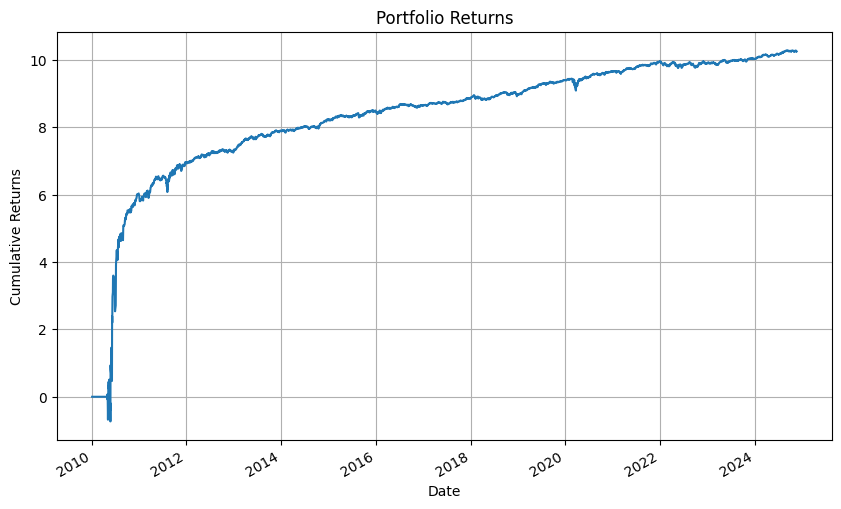

In [ ]:
metrics_calculator = ExtendedMetrics()
metrics = metrics_calculator.calculate(portfolio_values_df['Portfolio Value'],
                                        portfolio_returns,
                                        benchmark_returns=spy_returns)
print("\nPerformance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
metrics_calculator.plot_returns(portfolio_returns)
# 0.72 sharpe consistent with literature